# FESDModel

FESD - Fault estimation for skeleton detection - is a suite that aims at finding faults in joints of skeletons, which are detected by human pose estimatiors.

FESDData is the sister project to this notebook, which aims at recording depth and rgb data, as well as populating the data with human poses from variing human pose estimators.

Furthermore, FESTData augments all data based on joint confidence.

FFESDModel aims to develop and evaluate a model based on the faulty and augmented joint data as well as RGBD data.

## Libraries

We need a range of libraries which are imported here. We also define some constants.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
import os
from pathlib import Path
from time import time

from data import FESDDataset, err2gt, gt2err
from data import Frame, AugmentationParams
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

import cv2

from model import FESD, train, val, test
import copy

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

import tensorflow as tf
import datetime

from utils import AvgMeter, clip_gradient, get_scheduler

from tqdm import tqdm

num_gpus = torch.cuda.device_count()
print(f"Num cuda GPUs: {num_gpus}")
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

h:\FESD\FESDModel\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Num cuda GPUs: 1


In [3]:
RECORDING_DIR = Path('H:/Recordings/')
CHECKPOINT_DIR = Path('checkpoints')

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

In [4]:
# Reduce number of frames

# for file in os.listdir(RECORDING_DIR):
#   if (file.endswith('.json')):
#     with open(file=os.path.join(RECORDING_DIR, file), mode="r") as jsonFile:
#       data = json.load(jsonFile)
      
#     data["Frames"] = 30

#     with open(file=os.path.join(RECORDING_DIR, file), mode="w") as jsonFile:
#       json.dump(data, jsonFile)

In [5]:
# Reduce number of frames

# for file in os.listdir(RECORDING_DIR):
#   if (file.endswith('.json')):
#     with open(file=os.path.join(RECORDING_DIR, file), mode="r") as jsonFile:
#       data = json.load(jsonFile)

#     with open(file=RECORDING_DIR /  data['Skeleton'], mode='r') as skelFile:
#       skeleton_json = json.load(skelFile)
  
#     for frame in skeleton_json:
#       # remove index 0, 10, 16, 20, 24
#       for skeleton in frame:
#         skeleton['Skeleton'] = [skeleton['Skeleton'][i] for i in range(len(skeleton['Skeleton'])) if i not in [0, 10, 16, 20, 24]]
    
#     with open(file=RECORDING_DIR /  data['Skeleton'], mode="w") as skelFile:
#       json.dump(skeleton_json, skelFile)
    

## Data Loading

Firstly we need to import all the recordings into the notebook.


In [4]:
with open(file="Exercises.json", mode='r') as file:
  exercises_json = json.load(file)['Exercises']

with open(file="JointErrors.json", mode='r') as file:
  joint_error_json = json.load(file)

with open(file="SkeletonErrors.json", mode='r') as file:
  skeleton_error_json = json.load(file)

len(exercises_json)

13

In [5]:
batchsize = 10
train_size = 300
train_eval_split = 0.8
joint_names = ["-", "Head", "Neck", "Torso", "Waist", "Left collar", "Left shoulder", "Left elbow", "Left wrist", "Left hand", "-", "Right collar", "Right shoulder", "Right elbow", "Right wrist", "Right hand", "-", "Left hip", "Left knee", "Left ankle", "-", "Right hip", "Right knee", "Right ankle", "-"]

dataset_train = FESDDataset(RECORDING_DIR, train_size, test=False, val=False, train_eval_split=train_eval_split)
dataset_train.randomize_augmentation_params = True

dataset_eval = FESDDataset(RECORDING_DIR, train_size, test=False, val=True, train_eval_split=train_eval_split)
dataset_test = FESDDataset(RECORDING_DIR, train_size, test=True)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize)
validation_loader = torch.utils.data.DataLoader(dataset_eval, batch_size=batchsize)
test_loader = torch.utils.data.DataLoader(dataset_test)

# werbung-gravuren
print(len(train_loader))
print(len(validation_loader))
print(len(test_loader))
print(len(joint_names))

Recordings Found: 17
Total Frames: 408
Recordings Found: 17
Total Frames: 102
Recordings Found: 8
Total Frames: 240
41
11
240
25


In [6]:
rgb, depth, pose_2d, gt = dataset_train[0]
dataset_train.frame.show()

print(rgb.shape, depth.shape, pose_2d.shape, gt.shape)
gt2err(gt)

H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 0
torch.Size([3, 300, 300]) torch.Size([1, 300, 300]) torch.Size([3, 20]) torch.Size([80])


(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
         0., 2.]),
 tensor([0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754,
         0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754,
         0.4754, 0.4754]))

In [7]:
cols = ['Exercise', 'Type'] + [f'{x}' for x in range(len(gt2err(gt)[0]))]
df = pd.DataFrame(columns=cols)

In [9]:
for i in range(0, len(dataset_train)):
  _, _, _, gt = dataset_train[i]
  frame = dataset_train.frame

  row = [frame.session['Session Parameters']['Exercise'], "Train"]
  row += list(map(int, gt2err(gt)[0].tolist()))

  df.loc[i] = row

H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 0
H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 10
H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 20
H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 30
H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 40
H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 50
H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 60
H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 70
H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 80
H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 90
H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 100
H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 110
H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 120
H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 130
H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 140
H:\Recordings\Session_2023-02-28T22.58.23\SkeletonNui.json 150
H:\

In [10]:
for i in range(len(dataset_train), len(dataset_eval)):
  _, _, _, gt = dataset_eval[i]
  frame = dataset_eval.frame

  row = [frame.session['Session Parameters']['Exercise'], "Eval"]
  row += list(map(int, gt2err(gt)[0].tolist()))

  df.loc[i] = row

In [11]:
for i in range(len(dataset_eval) + len(dataset_train), len(dataset_test)):
  _, _, _, gt = dataset_test[i]
  frame = dataset_test.frame

  row = [frame.session['Session Parameters']['Exercise'], "Test"]
  row += list(map(int, gt2err(gt)[0].tolist()))

  df.loc[i] = row


df

,Exercise,Type,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,E-0.00,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,2
1,E-0.00,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,2
2,E-0.00,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,2
3,E-0.00,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,2
4,E-0.00,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,E-3.02,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
404,E-3.02,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
405,E-3.02,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
406,E-3.02,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df[[f'{x}' for x in range(len(gt2err(gt)[0]))]] != 0

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
404,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
405,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
406,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [15]:
df["Difficulty"] = df["Exercise"].apply(lambda x: int(x[2]))
# df[[f'{x}' for x in range(len(dataset_train.gt2err(gt)[0]))]] = df[[f'{x}' for x in range(len(dataset_train.gt2err(gt)[0]))]].astype(int)
df.head()

,Exercise,Type,0,1,2,3,4,5,6,7,...,11,12,13,14,15,16,17,18,19,Difficulty
0,E-0.00,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,2,0
1,E-0.00,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,2,0
2,E-0.00,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,2,0
3,E-0.00,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,2,0
4,E-0.00,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,2,0


In [21]:
df.columns

Index(['Exercise', 'Type', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       'Difficulty'],
      dtype='object')

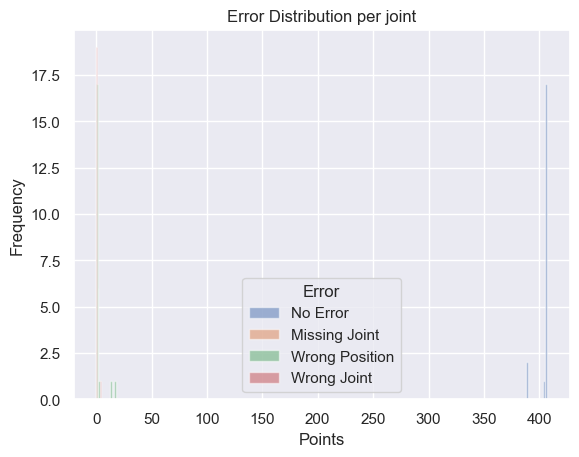

In [20]:
e0 = (df[[f'{x}' for x in range(len(gt2err(gt)[0]))]][df[[f'{x}' for x in range(len(gt2err(gt)[0]))]] == 0] + 1).sum(axis=0)
e1 = (df[[f'{x}' for x in range(len(gt2err(gt)[0]))]][df[[f'{x}' for x in range(len(gt2err(gt)[0]))]] == 1] + 0).sum(axis=0)
e2 = (df[[f'{x}' for x in range(len(gt2err(gt)[0]))]][df[[f'{x}' for x in range(len(gt2err(gt)[0]))]] == 2] - 1).sum(axis=0)
e3 = (df[[f'{x}' for x in range(len(gt2err(gt)[0]))]][df[[f'{x}' for x in range(len(gt2err(gt)[0]))]] == 3] - 2).sum(axis=0)

#add three histograms to one plot
plt.hist(e0, alpha=0.5, label='No Error')
plt.hist(e1, alpha=0.5, label='Missing Joint')
plt.hist(e2, alpha=0.5, label='Wrong Position')
plt.hist(e3, alpha=0.5, label='Wrong Joint')

#add plot title and axis labels
plt.title('Error Distribution per joint')
plt.xlabel('Points')
plt.ylabel('Frequency')

#add legend
plt.legend(title='Error')

#display plot
plt.show()

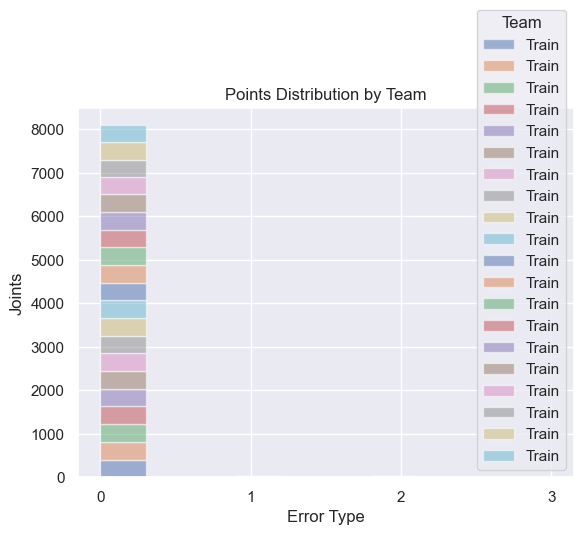

In [22]:
df_type = df[["Type"] + [f'{x}' for x in range(len(gt2err(gt)[0]))]]

#add three histograms to one plot
plt.hist(df[[f'{x}' for x in range(len(gt2err(gt)[0]))]], label=df["Type"], alpha=0.5, histtype='barstacked')

#add plot title and axis labels
plt.title('Points Distribution by Team')
plt.xlabel('Error Type')
plt.ylabel('Joints')
plt.xticks([0,1,2,3])

#add legend
plt.legend(title='Team')

#display plot
plt.show()

### Build Model


In [19]:
model = FESD()
print(model)

model = nn.DataParallel(model).cuda()

FESD(
  (rgb_conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rgb_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rgb_conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rgb_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rgb_conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rgb_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (depth_conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (depth_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (depth_conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (depth_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (depth_conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (depth_pool3): MaxPool2d(kernel_size=2, stride

## Train Model

In the following we define the training function and train a network on the training data.

In [20]:
# epoch number
epochs = 100
# optimizer
optim = 'adam'
# learning rate
learning_rate = 0.000025
# learning rate scheduler. can be step, poly or cosine
lr_scheduler = 'cosine'
# warmup epoch
warmup_epoch = -1
# warmup multiplier
warmup_multiplier = 100
# for step scheduler. where to decay lr, can be a list
lr_decay_epochs = [120, 160, 200]
# for step scheduler. step size to decay lr
lr_decay_steps = 20 
# for step scheduler. decay rate for learning rate
lr_decay_rate = 0.01
# weight decay
weight_decay = 0.0001
# momentum for SGD
momentum = 0.9
# gradient clipping margin
clip = 0.5

In [21]:
n_data = len(train_loader.dataset)
CE = torch.nn.CrossEntropyLoss().cuda()

if optim == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
elif optim == 'adamW':
    optimizer = torch.optim.AdamW(model.parameters(), learning_rate, weight_decay=weight_decay)
elif optim == 'sdg':
    optimizer = torch.optim.SGD(model.parameters(), learning_rate / 10.0 * batchsize, momentum=momentum, weight_decay=weight_decay)

scheduler = get_scheduler(optimizer, len(train_loader), lr_scheduler, lr_decay_epochs, lr_decay_steps, lr_decay_rate, epochs, warmup_epoch, warmup_multiplier)

In [23]:
# routine
for epoch in range(1, epochs + 1):
    
    tic = time()

    torch.cuda.empty_cache()
    train(train_loader, model, optimizer, CE, scheduler, clip, epoch, epochs, writer)

    torch.cuda.empty_cache()
    # val(validation_loader, model, CE, epoch, epochs, writer)
    print(f'epoch {epoch}, total time {time() - tic:.2f}, learning_rate {optimizer.param_groups[0]["lr"]}')

    if (epoch) % 10 == 0:
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"{epoch}_ckpt.pth"))

        print("checkpoint saved {}!".format(os.path.join(CHECKPOINT_DIR, f"{epoch}_ckpt.pth")))
        
torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, f"last_ckpt.pth"))
print(f"model saved {os.path.join(CHECKPOINT_DIR, f'last_ckpt.pth')}!")
checkpoint = os.path.join(CHECKPOINT_DIR, f"last_ckpt.pth")

torch.Size([10, 80]) torch.Size([10, 80])


TypeError: add_scalar() got multiple values for argument 'global_step'

In [ ]:
input_names = ["RGB", "Depth", "Joints"]
output_names = ["Errors"]

torch.onnx.export(model, (rgb, depth, pose_2d), 'FESD.onnx', input_names=input_names, output_names=output_names)

In [ ]:
 torch.cuda.empty_cache()

In [ ]:
from data import gts2errs, errs2gts
torch.cuda.empty_cache()
rgb, depth, pose_2d, errors = dataset_train[0]
print(gts2errs(model(rgb, depth, pose_2d)))
print(gt2err(errors))

(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 1.]]), tensor([[0.9806, 0.9714, 0.9753, 0.9623, 0.9782, 0.9529, 0.9812, 0.9592, 0.9403,
         0.8790, 0.9813, 0.9689, 0.9529, 0.9732, 0.9783, 0.9367, 0.9823, 0.9540,
         0.9600, 0.7591, 0.9755, 0.9576, 0.9646, 0.7245, 0.9892]],
       grad_fn=<CopySlices>))
(tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 2., 1., 0., 0., 2., 1.]), tensor([0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754,
        0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754,
        0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754, 0.4754]))
